# 커널 서포트 벡터 머신

## XOR 문제

퍼셉트론이나 서포트 벡터 머신과 같은 선형 판별 함수 기반 모형은 다음과 같은 XOR(exclusive OR) 문제를 풀지 못한다는 단점이 있다. 

| | Y=0 | Y=1 |
|-|-|-|
|X=0| 0 | 1 |
|X=1| 1 | 0 | 

이러한 경우에는 선형 판별 평면(decision hyperplane)으로 영역을 나눌 수 없기 때문이다.

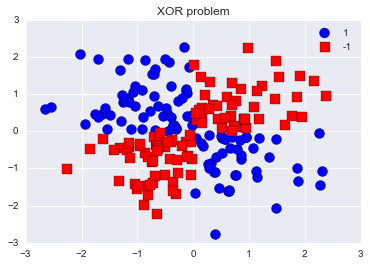

In [18]:
np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='b', marker='o', label='1', s=100)
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1], c='r', marker='s', label='-1', s=100)
plt.ylim(-3.0)
plt.legend()
plt.title("XOR problem")
plt.show()

In [19]:
def plot_xor(X, y, model, title, xmin=-3, xmax=3, ymin=-3, ymax=3):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000), np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y== 1, 0], X[y== 1, 1], c='b', marker='o', label='+1', s=100)
    plt.scatter(X[y==-1, 0], X[y==-1, 1], c='r', marker='s', label='-1', s=100)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.show()

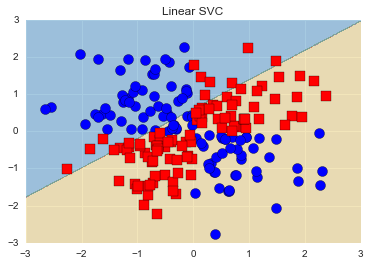

In [20]:
from sklearn.svm import SVC

svc = SVC(kernel='linear').fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, svc, 'Linear SVC')

## 기저 함수를 사용한 비선형 판별 모형

이러한 경우 도움이 되는 것이 원래의 $D$ 차원 독립 변수 벡터 $x$ 대신 기저 함수(basis function)으로 변환한 $M$ 차원 벡터 $\phi(x)$를 독립 변수 벡터로 사용하는 방법이다.

$$ \phi(\cdot): \mathbf{R}^D \rightarrow \mathbf{R}^M $$

$$ (x_1, x_2, \cdots, x_D) \;\;\; \rightarrow \;\;\; \phi(x) = (\phi_1(x), \phi_2(x), \cdots, \phi_M(x)) $$

앞서 XOR 문제를 풀기 위해 다음과 같이 상호 곱(cross-multiplication) 항을 추가한 기저 함수를 사용해 보자.


$$ (x_1, x_2) \;\;\; \rightarrow \;\;\; \phi(x) = (x_1^2, 2x_1x_2, x_2^2) $$

In [21]:
from sklearn.preprocessing import FunctionTransformer

def basis(X):
    return np.vstack([X[:, 0]**2, np.sqrt(2)*X[:, 0]*X[:, 1], X[:, 1]**2]).T

X = np.arange(8).reshape(4, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [22]:
FunctionTransformer(basis).fit_transform(X)

array([[  0.        ,   0.        ,   1.        ],
       [  4.        ,   8.48528137,   9.        ],
       [ 16.        ,  28.28427125,  25.        ],
       [ 36.        ,  59.39696962,  49.        ]])

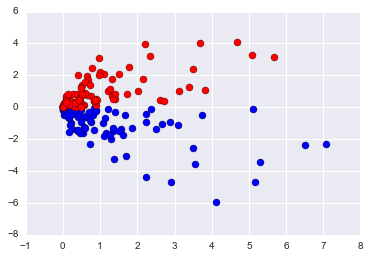

In [23]:
X_xor2 = FunctionTransformer(basis).fit_transform(X_xor)
plt.scatter(X_xor2[y_xor== 1, 0], X_xor2[y_xor== 1, 1], c="b", s=50)
plt.scatter(X_xor2[y_xor==-1, 0], X_xor2[y_xor==-1, 1], c="r", s=50)
plt.show()

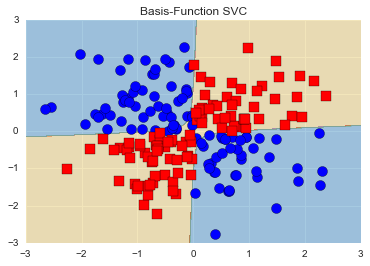

In [24]:
from sklearn.pipeline import Pipeline

basismodel = Pipeline([('basis', FunctionTransformer(basis)), ('svc', SVC(kernel='linear'))]).fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, basismodel, 'Basis-Function SVC')

## 커널 트릭

서포트 벡터 머신의 경우 목적 함수와 예측 모형은 다음과 같은 dual form으로 표현할 수 있다.

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m x_n^T x_m
$$


$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n x_n^T x - w_0
$$

이 수식에서 $x$를 기저함수 변환으로 $\phi(x)$로 바꾸면

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m \phi(x_n)^T \phi(x_m)
$$


$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n \phi(x_n)^T \phi(x) - w_0
$$

이 된다. 즉 모든 기저함수는 $\phi(x_i)^T\phi(x_j)$의 형태로만 사용되며 독립적으로 사용되지 않는다.

따라서 두 개의 변환된 독립 변수 벡터를 내적(inner product) 한 값 $\phi(x_i)^T\phi(x_j)$를 하나의 함수로 나타낼 수 있다.

$$ k(x_i, x_j) = \phi(x_i)^T \phi(x_j) $$

이러한  함수를 커널(kernel)이라고 한다.

1차로는 절대 안 쓰인다. 2차로만 쓰인다. 커널함수를 만들어서 한꺼번에 계산하는 것을 만들자는 것이 k이다. 왜 그러냐? 계산량이 적다. 또 다른 이유들은? 핵심적인 장점은 디자인을 할 수 있는 자유도가 높아진다. 커널 펑션은 스칼라값이다. 커널 디자인이 훨씬 쉬워진다. 다양한 커널들을 사용할 수 있다. 커널은 벡터 2개가 들어가서 스칼라값만 나오는 것

커널을 사용하면 변환과 내적에 들어가는 계산량이 줄어든다. 예를 들어, 다음과 같은 기저함수의 경우

$$ \phi(x) = \phi([x_1, x_2]) = (x_1^2, \sqrt{2}x_1x_2, x_2^2) $$

커널 방법을 쓰지 않을 경우에 $ \phi(x_i)^T \phi(x_j) $를 계산하려면 $4 + 4 + 3 = 11$ 번의 곱셈을 해야 한다.

그런데 이 기저함수는 다음과 같은 커널로 대체가능하다.

$$ 
\begin{eqnarray}
k(x, y) 
&=& (x^Ty)^2 \\
&=& (x_1y_1 + x_2y_2)^2 \\
&=& x_1^2y_1^2 + 2x_1x_2y_1y_2 + x_2^2y_2^2 \\
&=& (x_1^2, \sqrt{2}x_1x_2, x_2^2)  (y_1^2, \sqrt{2}y_1y_2, y_2^2)^T \\
&=& \phi(x)^T \phi(y)
\end{eqnarray}
$$


이 커널을 사용하면  $ \phi(x)^T \phi(y) $ 을 계산하는데 $2 + 1 = 3$ 번의 곱셈이면 된다.
 

## 많이 사용되는 커널

대응하는 기저함수가 존재할 수만 있다면 커널을 먼저 정의해도 된다. 다음과 같은 커널들이 대표적인 예이다. 이 커널들은 대부분 기저함수로 변환하였을 때 무한대의 차원을 가지는 기저 함수가 된다. 따라서 대부분의 비선형성을 처리할 수 있다.

* 커널을 사용하지 않는 경우

$$ k(x, y) = x^Ty $$


* 다항 커널 (Polynomial Kernel)

$$ k(x, y) = (\gamma (x^Ty) + \theta)^d $$


* RBF(Radial Basis Function) 또는 가우시안 커널 (Gaussian Kernel)

$$ k(x, y) = \exp \left( -\gamma ||x-y||^2 \right) $$


* 시그모이드 커널 (Sigmoid Kernel)

$$ k(x, y) = \tanh(\gamma (x^Ty) + \theta) $$


앞에서 사용한 기저함수는 $\gamma = 1, \theta= 0, d=2$ 인 다항 커널임을 알 수 있다.

4가지만 있지만 파라미터들을 줄 수 있기 때문에 여러가지 늘릴 수가 있다. 아까는 폴리노미얼 감마가 1, 세타가 0, d가 2. 파라미터 주는 것은 분포를 보고 나서 trial and err로 주어야 한다.

* RBF 방식은 OVO 방식인가요? 네 맞다고 합니다.

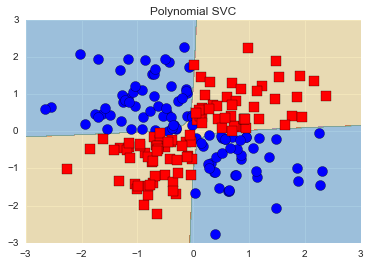

In [25]:
polysvc = SVC(kernel='poly', degree=2, gamma=1, coef0=0).fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, polysvc, 'Polynomial SVC')

## 커널의 의미

서포트 벡터 머신의 목적 함수와 예측 모형은 커널을 사용하여 표현하면 다음과 같다.

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m k(x_n, x_m)
$$


$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n k(x_n, x) - w_0
$$

커널을 사용하지 않는 경우 $ k(x, y) = x^Ty $라는 점을 고려하면 커널은 다음과 같은 특징을 보인다.

* $x$와 $y$가 동일한 벡터일 때 가장 크고
* 두 벡터간의 거리가 멀어질 수록 작아진다.

즉, 두 표본 데이터 간의 유사도(similarity)를 측정하는 기준으로 볼 수도 있다. 가장 대표적인 것이 RBF 커널이다.

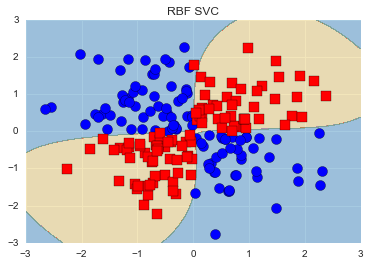

In [26]:
rbfsvc = SVC(kernel='rbf').fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, rbfsvc, 'RBF SVC')

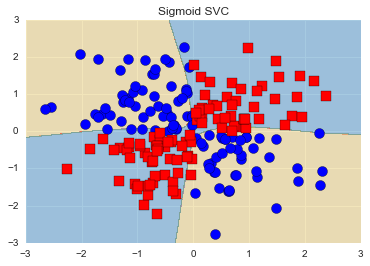

In [27]:
sigmoidsvc = SVC(kernel='sigmoid', gamma=2, coef0=2).fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, sigmoidsvc, 'Sigmoid SVC')

## 커널 파라미터

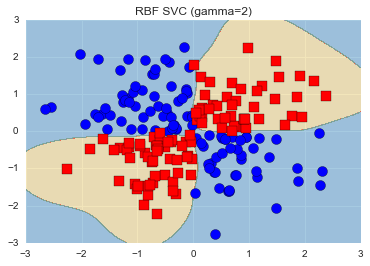

In [28]:
plot_xor(X_xor, y_xor, SVC(kernel='rbf', gamma=2).fit(X_xor, y_xor), 'RBF SVC (gamma=2)')

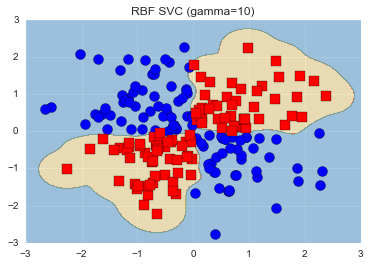

In [30]:
plot_xor(X_xor, y_xor, SVC(kernel='rbf', gamma=10).fit(X_xor, y_xor), 'RBF SVC (gamma=10)')

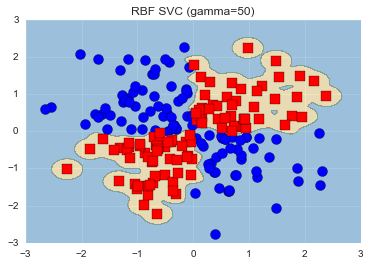

In [31]:
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=50).fit(X_xor, y_xor), "RBF SVC (gamma=50)")

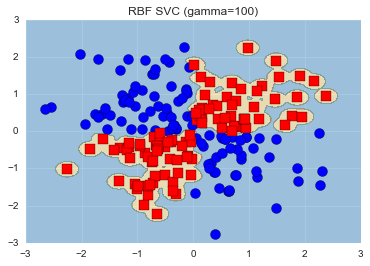

In [32]:
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=100).fit(X_xor, y_xor), "RBF SVC (gamma=100)")

## 예 : Iris 

In [33]:
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
X_combined = np.hstack((y_train, y_test))

def plot_iris(X, y, model, title, xmin=-2.5, xmax=2.5, ymin=-2.5, ymax=2.5):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000), np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y==0, 0], X[y==0, 1], c='r', marker='^', label='0', s=100)
    plt.scatter(X[y==1, 0], X[y==1, 1], c='g', marker='o', label='1', s=100)
    plt.scatter(X[y==2, 0], X[y==2, 1], c='b', marker='s', label='2', s=100)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.show()

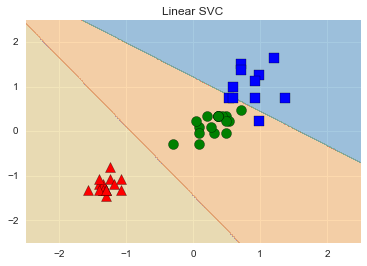

In [34]:
model = SVC(kernel='linear').fit(X_test_std, y_test)
plot_iris(X_test_std, y_test, model, 'Linear SVC')

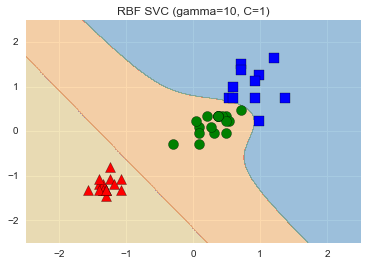

In [35]:
model = SVC(kernel='poly', random_state=0, gamma=10, C=1.0).fit(X_test_std, y_test)
plot_iris(X_test_std, y_test, model, 'RBF SVC (gamma=10, C=1)')

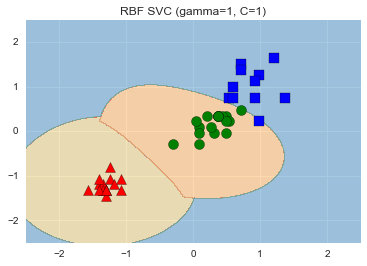

In [36]:
model = SVC(kernel='rbf', random_state=0, gamma=1, C=1.0).fit(X_test_std, y_test)
plot_iris(X_test_std, y_test, model, "RBF SVC (gamma=1, C=1)")

* KSVM에서 사실 가장 많이 쓰이는 커널함수는 RBF이다.
* 왜? 커널을 사용하지 않을 경우에는 직선으로 나오고 방향을 기준으로 한다. RBF는 원으로 나온다. 실제 물리적인 거리를 기준으로 하기 때문에
* RBF커널은 감마가 커지면 거리에 대한 가중치를 더 주겠다. 그래서 조금만 떨어져도 많이 떨어진 것으로 생각하겠다는 의미
* 감마 1과 2의 차이. 울퉁불퉁해졌다. 갈수록 울퉁불퉁해진다.

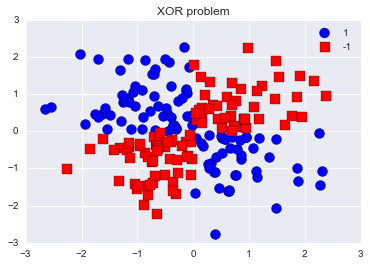

In [37]:
np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor==1,0], X_xor[y_xor==1,1], c='b', marker='o', label='1', s=100)
plt.scatter(X_xor[y_xor==-1,0], X_xor[y_xor==-1,1], c='r', marker='s', label='-1', s=100)
plt.ylim(-3.0)
plt.legend()
plt.title("XOR problem")
plt.show()

In [38]:
def plot_xor(model, title="", X=X_xor, y=y_xor, xmin=-3, xmax=3, ymin=-3, ymax=3):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000), np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y== 1, 0], X[y== 1, 1], c='b', marker='o', label='+1', s=100)
    plt.scatter(X[y==-1, 0], X[y==-1, 1], c='r', marker='s', label='-1', s=100)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.show()

In [39]:
def plot_xor(model, title="", X=X_xor, y=y_xor, xmin=-3, xmax=3, ymin=-3, ymax=3):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000), np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y== 1, 0], X[y== 1, 1], c='b', marker='o', label='+1', s=100)
    plt.scatter(X[y==-1, 0], X[y==-1, 1], c='r', marker='s', label='-1', s=100)
    plt.scatter(model.support_vectors_[y[model.support_]==1, 0], model.support_vectors_[y[model.support_]==1, 1],
               c='b', marker='o', s=150, linewidth=3, facecolor=None)
    plt.scatter(model.support_vectors_[y[model.support_]==-1, 0], model.support_vectors_[y[model.support_]==-1, 1],
               c='r', marker='s', s=150, linewidth=3, facecolor=None)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.show()

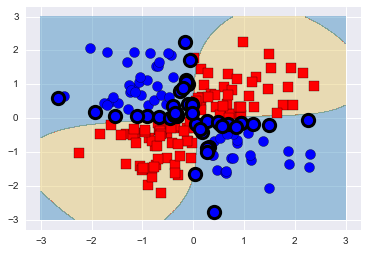

In [40]:
#연습
from sklearn.svm import SVC

rbfsvc = SVC(kernel="rbf", C=1).fit(X_xor, y_xor)
XX, YY = np.meshgrid(np.arange(-3, 3, 6/1000), np.arange(-3, 3, 6/1000))
ZZ = np.reshape(rbfsvc.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
plt.scatter(X_xor[y_xor== 1, 0], X_xor[y_xor== 1, 1], c='b', marker='o', label='+1', s=100)
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1], c='r', marker='s', label='-1', s=100)
plt.scatter(rbfsvc.support_vectors_[y_xor[rbfsvc.support_]==1, 0], rbfsvc.support_vectors_[y_xor[rbfsvc.support_]==1, 1],
               c='b', marker='o', s=150, linewidth=3, facecolor=None)

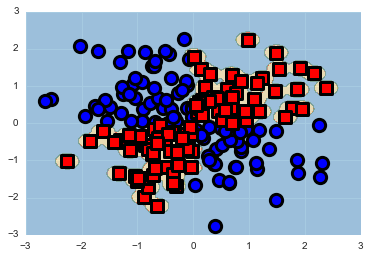

In [41]:
rbfsvc = SVC(kernel="rbf", gamma=100, C=100).fit(X_xor, y_xor)   
#감마가 커질수록 서포트가 많아진다. 다 바운더리에 영향을 미친다. 
#그래서 모양이 구불구불해지는 것이다. 100까지 갔을 경우에 엄청 구불구불해지는 것인데 그럴 수록 오버피팅이 커지는 것이다.
#RBF는 모양 예측이 쉽다. 영역별로 뭉쳐지는 바운더리로 보면 되고 그것을 조정하는 것이 감마이다.
#RBF는 기저벡터를 무한대의 차원으로 바라보고 잡아낼 수 있다. 무한대의 basis function으로 쪼갤 수 있다는 점
plot_xor(rbfsvc)